## Unique Conditions Modelling
This code will investigate the number of unique conditions a pet can have using a number of neural network techniques. 

Source code inspired by https://laub.au/DeepLearningForActuaries/.

## 1. Imports
Importing necessary packages.

In [132]:
# Import libraries
import os
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss, confusion_matrix


from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Input, Dense, Embedding, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## 2. Data Import and Investigation
Importing compiled and cleaned data (as of 14/10 from Github) in file "cleaned_total_data.csv".

In [83]:
# Set working directory
os.chdir(r"C:\Users\ameli\OneDrive - UNSW\2024 Trimester 3\ACTL 4305 Actuarial Data Analytic Applications\Assignment")

# Import cleaned csv file
clean_data = pd.read_csv("cleaned_total_data.csv")

In [84]:
# Investigate dataset
clean_data.head()

,X,UW_Date,exposure_id,tenure.x,pet_gender,pet_de_sexed,pet_de_sexed_age,pet_is_switcher,nb_policy_first_inception_date,pet_age_months,...,cumulative_claim_amount,cumulative_claim_paid,cumulative_total_claim_amount,tenure.y,claim_frequency,breed_group,nb_excess_FLAG,has_claim,owner_age_band,majority_remoteness
0,2,1/01/2024,exposure_255c9ecf-fd74-4a50-83c4-58cbe79ba7b5,2,male,False,NaN,NaN,23/11/2023,17,...,0.000000,0.000000,0.000000,NaN,0.0,Medium/Active Dogs (Working/Sporting),False,False,30-39,Inner Regional Australia
1,3,1/01/2024,exposure_015a99a7-11ac-4719-b6ef-7446db50ea55,0,male,False,NaN,NaN,1/01/2024,21,...,0.000000,0.000000,0.000000,NaN,0.0,Unknown,True,False,20-29,Major Cities of Australia
2,4,1/01/2024,exposure_5f1f95f2-cae0-41c2-9e7b-a306192a4735,2,female,True,7-12 mo,NaN,23/11/2023,16,...,72.727273,58.181818,72.727273,2.0,1.0,Unknown,False,True,30-39,Inner Regional Australia
3,5,1/01/2024,exposure_040a594b-3127-4649-9943-e35ed0df5b36,2,male,False,NaN,NaN,8/11/2023,8,...,0.000000,0.000000,0.000000,NaN,0.0,Terriers,True,False,60-69,Major Cities of Australia
4,6,1/01/2024,exposure_674df505-e2b3-468f-b2f1-acc399add0d3,0,female,True,0-3 mo,NaN,4/01/2024,15,...,0.000000,0.000000,0.000000,NaN,0.0,Medium/Active Dogs (Working/Sporting),True,False,20-29,Major Cities of Australia


Note to view some of the next few as scrollable elements.

In [85]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40491 entries, 0 to 40490
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               40491 non-null  int64  
 1   UW_Date                         40491 non-null  object 
 2   exposure_id                     40491 non-null  object 
 3   tenure.x                        40491 non-null  int64  
 4   pet_gender                      40491 non-null  object 
 5   pet_de_sexed                    40491 non-null  bool   
 6   pet_de_sexed_age                12439 non-null  object 
 7   pet_is_switcher                 9437 non-null   object 
 8   nb_policy_first_inception_date  40491 non-null  object 
 9   pet_age_months                  40491 non-null  int64  
 10  nb_contribution                 40491 non-null  int64  
 11  nb_excess                       40491 non-null  int64  
 12  nb_address_type_adj             

In [86]:
# Investigate ranges of variables
for i in clean_data.columns:
    print(i)
    print(clean_data[i].value_counts().sort_index(ascending = True))

X
X
2        1
3        1
4        1
5        1
6        1
        ..
41597    1
41598    1
41599    1
41600    1
41601    1
Name: count, Length: 40491, dtype: int64
UW_Date
UW_Date
1/01/2024    1936
1/02/2024    2666
1/03/2024    3443
1/04/2024    4374
1/05/2024    5359
1/06/2024    6337
1/07/2024    7563
1/08/2024    8813
Name: count, dtype: int64
exposure_id
exposure_id
exposure_000a0128-7995-4e26-91e2-fda217a5837d    4
exposure_000e4bc1-8623-43a5-a47f-3685d8d084be    2
exposure_000f48d8-d205-4ea8-839d-cceadde43de8    3
exposure_0014590f-b9e6-4122-9dc3-2e16003a5bd7    8
exposure_0015ad7c-fe8d-46fe-88a5-f15505d770cd    1
                                                ..
exposure_ffd78146-8b16-4e19-a08c-23e8cf654afb    8
exposure_ffddd3b6-2a3c-4e43-86bf-97c12d02c239    1
exposure_ffe25e6d-0e3d-4862-8d8e-6702270e03c9    2
exposure_ffe53208-f2f3-45d5-88cc-a51446319217    5
exposure_ffea43a0-1395-4e36-8128-8fafb3fddc03    1
Name: count, Length: 9235, dtype: int64
tenure.x
tenure.x
-7   

Going to take a smaller sample of the dataset for analysis right now, based on variables that might be most important. Others can be added on later. 

This means I will take:
- pet_gender
- pet_de_sexed
- pet_de_sexed_age
- pet_age_months
- nb_contribution
- nb_excess
- pet_age_years
- owner_age_years
- nb_breed_trait
- is_multi_pet_plan
- multiple_claims

I will not take (just yet):
- person_dob

In [87]:
# Create smaller dataframe
key_data = clean_data[["pet_gender", "pet_de_sexed", "pet_de_sexed_age", "pet_age_months", 
                       "nb_contribution", "nb_excess", "pet_age_years", "owner_age_years",
                       "nb_breed_trait", "is_multi_pet_plan", "multiple_claims", 
                       "num_unique_conditions"]]

In [88]:
# Understand the values these limited variables take on
for i in key_data.columns:
    print(i)
    print(key_data[i].value_counts().sort_index(ascending = True))

pet_gender
pet_gender
female    18289
male      22202
Name: count, dtype: int64
pet_de_sexed
pet_de_sexed
False    28052
True     12439
Name: count, dtype: int64
pet_de_sexed_age
pet_de_sexed_age
0-3 mo         1434
0-3 months        8
1-2 yr         2145
2+ years          8
2+ yr           673
4-6 mo         3765
7-12 mo        3800
7-12 months       8
Not Sure        598
Name: count, dtype: int64
pet_age_months
pet_age_months
1       282
2      6188
3      5692
4      2805
5      1544
       ... 
115       3
116       8
118       1
119      11
120       9
Name: count, Length: 118, dtype: int64
nb_contribution
nb_contribution
80     27022
90      8166
100     5303
Name: count, dtype: int64
nb_excess
nb_excess
0       6098
100    26189
200     8204
Name: count, dtype: int64
pet_age_years
pet_age_years
0-6 months     17548
1 years         5383
10 years           9
2 years         5213
3 years         3766
4 years         2663
5 years         1184
6 years          545
7 years          34

In [89]:
# Understand the missing values
print(key_data.isna().sum())


pet_gender                   0
pet_de_sexed                 0
pet_de_sexed_age         28052
pet_age_months               0
nb_contribution              0
nb_excess                    0
pet_age_years                0
owner_age_years             73
nb_breed_trait            2558
is_multi_pet_plan            0
multiple_claims              0
num_unique_conditions        0
dtype: int64


### A few notes on data quality:
The pet_de_sexed_age variable seems to have repeated categories (e.g. assuming 0-3 mo is the same as 0-3 months). Additionally, it has many missing values which should surely be coded as "Not Sure". When pre-processing, this needs to be considered as an ordinal, categorical variable - struggling with how to reconcile this with the "Not Sure" category. 

Owner age years missing values seem to be low, happy to have that imputed with the mean during pre-processing. Need to check and make sure the "months" aren't counted as years. 

Missing breed trait variables also aren't too worrying, there is an "unknown" category that the NA values should be allocated to. 


#### Pet_De_Sexed_Age
Data cleaning this specific variable as mentioned above.

In [90]:
# Merge the categories that are doubling up
key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].replace("0-3 months", "0-3 mo")
key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].replace("2+ years", "2+ yr")
key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].replace("7-12 months", "7-12 mo")


C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\2762557314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].replace("0-3 months", "0-3 mo")
C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\2762557314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].replace("2+ years", "2+ yr")
C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\2762557314.py:4: SettingWithCopyWarning: 
A value is tr

In [91]:
# Allocate the missing values to the "Not Sure" category
key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].fillna("Not Sure")

C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\2442574469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].fillna("Not Sure")


In [92]:
# Confirm the categories are aligned now and there are no missing values
print(key_data["pet_de_sexed_age"].value_counts().sort_index(ascending = True))
print(key_data["pet_de_sexed_age"].isna().sum())

pet_de_sexed_age
0-3 mo       1442
1-2 yr       2145
2+ yr         681
4-6 mo       3765
7-12 mo      3808
Not Sure    28650
Name: count, dtype: int64
0


#### Breed Trait
Need to allocate unknowns.

In [93]:
# Allocate the missing values to the "unknown" category
key_data["nb_breed_trait"] = key_data["nb_breed_trait"].fillna("unknown")

C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\2141764739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data["nb_breed_trait"] = key_data["nb_breed_trait"].fillna("unknown")


In [94]:
# Confirm allocation worked
print(key_data["nb_breed_trait"].isna().sum())

0


## 3. Data Pre-Processing
This is detailed in the notion page, at the bottom of the modelling master document.

#### Stratified Split
Splitting dataset into training, testing and validation sets. 

In [95]:
# Initialise pre-processing by splitting into target and variables
target = key_data["num_unique_conditions"]
variables = key_data.drop("num_unique_conditions", axis = 1)

# Split into training, testing and validation datasets
X_main, X_test, y_main, y_test = train_test_split(variables, target, test_size = 0.2, 
                                                  random_state = 199, stratify = target)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size = 0.25, 
                                                  random_state = 199, stratify = y_main)

X_train.shape, X_val.shape, X_test.shape

((24294, 11), (8098, 11), (8099, 11))

#### Splitting Variable Types
Need to now split the variables according to how they should be pre-processed, and check they're of the correct type.
- binary variables: pet gender, pet de-sexed, multi-pet plan, multiple claims
- ordinal categorical: pet de-sexed age, contribution, excess, pet_age_years
- nominal categorical: breed_trait
- numerical: pet age, owner age.

In [96]:
# Grouping the binary variables
binary_vars = key_data[["pet_gender", "pet_de_sexed", "is_multi_pet_plan", "multiple_claims"]]

# Checking the type of the binary variables
binary_vars.dtypes

pet_gender           object
pet_de_sexed           bool
is_multi_pet_plan      bool
multiple_claims        bool
dtype: object

In [97]:
# Grouping the categorical ordinal variables
ordinal_vars = key_data[["pet_de_sexed_age", "nb_contribution", "nb_excess", "pet_age_years"]]

# Checking the type of the ordinal variables
ordinal_vars.dtypes

# Convert the ordinal variables to category type
ordinal_vars["nb_contribution"] = ordinal_vars["nb_contribution"].astype("category")   
ordinal_vars["nb_excess"] = ordinal_vars["nb_excess"].astype("category")

# Checking the type of the ordinal variables
ordinal_vars.dtypes

C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\1614131768.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_vars["nb_contribution"] = ordinal_vars["nb_contribution"].astype("category")
C:\Users\ameli\AppData\Local\Temp\ipykernel_30192\1614131768.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_vars["nb_excess"] = ordinal_vars["nb_excess"].astype("category")


pet_de_sexed_age      object
nb_contribution     category
nb_excess           category
pet_age_years         object
dtype: object

In [98]:
# Grouping the categorical nominal variables
nominal_vars = key_data[["nb_breed_trait"]]

# Checking the type of the nominal variables
nominal_vars.dtypes

nb_breed_trait    object
dtype: object

In [99]:
# Grouping the continuous variables
num_vars = key_data[["pet_age_months", "owner_age_years"]]

# Checking the type of the continuous variables
num_vars.dtypes

pet_age_months       int64
owner_age_years    float64
dtype: object

#### Ordinal Encoding
Defining the order that the ordinal encoding needs to occur in, for several variables.

In [100]:
# Define the order for pet_de_sexed_age
pet_de_sexed_age_order = ["0-3 mo", "4-6 mo", "7-12 mo", "1-2 yr", "2+ yr", "Not Sure"]

# Define the order for pet_age_years
pet_age_years_order = ["0-6 months", "7-12 months", "1 years", "2 years", "3 years", "4 years",
                       "5 years", "6 years", "7 years", "8 years", "9 years", "10 years"]

Specify the ordinal categorical variables that can be encoded to default, and those that can't.

In [101]:
# Split into those that need special treatment and those that don't
ordinal_sp_vars = ordinal_vars[["pet_de_sexed_age", "pet_age_years"]]
ordinal_vars = ordinal_vars.drop(["pet_de_sexed_age", "pet_age_years"], axis = 1)

#### Transforming Variables


In [102]:
# Define how to pre-process the data
ct = make_column_transformer(
    (OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), ["nb_breed_trait"]),
    (OrdinalEncoder(categories = [pet_de_sexed_age_order, pet_age_years_order]), 
     ["pet_de_sexed_age", "pet_age_years"]),
    (OrdinalEncoder(), ["pet_gender", "pet_de_sexed", "nb_contribution", "nb_excess", 
     "is_multi_pet_plan", "multiple_claims"]),
    (make_pipeline(SimpleImputer(strategy = 'mean'), StandardScaler()), 
     ["pet_age_months", "owner_age_years"]),
    remainder = 'drop',
    verbose_feature_names_out = False
)

In [103]:
# Pre-process variables
X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)
X_test_ct = ct.transform(X_test)

In [104]:
# Check the shapes of processed data
for name, X in zip(('train', 'val', 'test'), (X_train_ct, X_val_ct, X_test_ct)):
        print(f'The {name} set has shape {X.shape}')

The train set has shape (24294, 30)
The val set has shape (8098, 30)
The test set has shape (8099, 30)


#### Transforming Target


In [105]:
# Check the order of the target variable
target.unique()

array([0, 1, 2, 3], dtype=int64)

In [106]:
# Ordinal encode the target variable
oe = OrdinalEncoder()

# Fit the encoder on the training data
y_train = oe.fit_transform(y_train.values.reshape(-1, 1))
y_val = oe.transform(y_val.values.reshape(-1, 1))
y_test = oe.transform(y_test.values.reshape(-1, 1))


In [109]:
# Checking the target variable shapes
y_train.shape, y_val.shape, y_test.shape


((24294, 1), (8098, 1), (8099, 1))

#### Confirming Ordinal Encoding
Need to confirm that the ordinal encoding has worked as expected (i.e. the categories that had a specific order have that retained).

In [113]:
# Check that the target variable is in the correct order
for i, value in enumerate(oe.categories_[0]):
    print(f"The # conditions {value} gets turned into {i}.")

The # conditions 0 gets turned into 0.
The # conditions 1 gets turned into 1.
The # conditions 2 gets turned into 2.
The # conditions 3 gets turned into 3.


In [117]:
# Access the fitted OrdinalEncoders
# Access the fitted OrdinalEncoders using transformers_
ordinal_encoders = []
for transformer in ct.transformers_:
    if isinstance(transformer[1], OrdinalEncoder):
        ordinal_encoders.append(transformer[1])  # Append the OrdinalEncoder to the list

# Iterate through each OrdinalEncoder to print the categories
for encoder in ordinal_encoders:
    if len(encoder.categories_) > 0:  
        for i, category in enumerate(encoder.categories_[0]):
            print(f"The 'pet_de_sexed_age' value '{category}' gets turned into {i}.")
        for i, category in enumerate(encoder.categories_[1]):
            print(f"The 'pet_age_years' value '{category}' gets turned into {i}.")

The 'pet_de_sexed_age' value '0-3 mo' gets turned into 0.
The 'pet_de_sexed_age' value '4-6 mo' gets turned into 1.
The 'pet_de_sexed_age' value '7-12 mo' gets turned into 2.
The 'pet_de_sexed_age' value '1-2 yr' gets turned into 3.
The 'pet_de_sexed_age' value '2+ yr' gets turned into 4.
The 'pet_de_sexed_age' value 'Not Sure' gets turned into 5.
The 'pet_age_years' value '0-6 months' gets turned into 0.
The 'pet_age_years' value '7-12 months' gets turned into 1.
The 'pet_age_years' value '1 years' gets turned into 2.
The 'pet_age_years' value '2 years' gets turned into 3.
The 'pet_age_years' value '3 years' gets turned into 4.
The 'pet_age_years' value '4 years' gets turned into 5.
The 'pet_age_years' value '5 years' gets turned into 6.
The 'pet_age_years' value '6 years' gets turned into 7.
The 'pet_age_years' value '7 years' gets turned into 8.
The 'pet_age_years' value '8 years' gets turned into 9.
The 'pet_age_years' value '9 years' gets turned into 10.
The 'pet_age_years' value 

## 4. Run Basic Neural Network
Will run a simple neural network which performs multi-class classification.

#### Initialising
Setting up a random seed for reproducibility and defining the classes in target variable.

In [119]:
# Setting random seed
seed = 199

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [126]:
# Define the number of classes
num_classes = len(oe.categories_[0])
num_classes

4

#### Sequential Neural Network

In [121]:
# Define the model structure
def create_model(seed = 199):
    random.seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct.shape[1:]))
    model.add(Dense(40, "leaky_relu"))
    model.add(Dense(20, "leaky_relu"))
    model.add(Dense(num_classes, "softmax"))
    return model

In [128]:
# Fit the model with early-stopping
model = create_model()

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])                                

es = EarlyStopping(patience = 50, restore_best_weights = True,
    monitor = "val_accuracy", verbose = 1)

hist_es = model.fit(X_train_ct, y_train, epochs = 1_000, validation_data = (X_val_ct, y_val), callbacks = [es], verbose = False);
history = hist_es.history

print(f"Stopped after {len(hist_es.history['loss'])} epochs.")

Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 37.
Stopped after 87 epochs.


In [129]:
# Evaluate the model
model.evaluate(X_train_ct, y_train, verbose = False)

[0.17447815835475922, 0.9539392590522766]

In [130]:
# Evaluate the model on the validation set
model.evaluate(X_val_ct, y_val, verbose=False)

[0.1921926885843277, 0.952333927154541]

In [131]:
# Find the f1 score for the validation set
y_pred = model.predict(X_val_ct)
y_pred = np.argmax(y_pred, axis = 1)
f1_score(y_val, y_pred, average = 'weighted')


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


0.9365028645293936

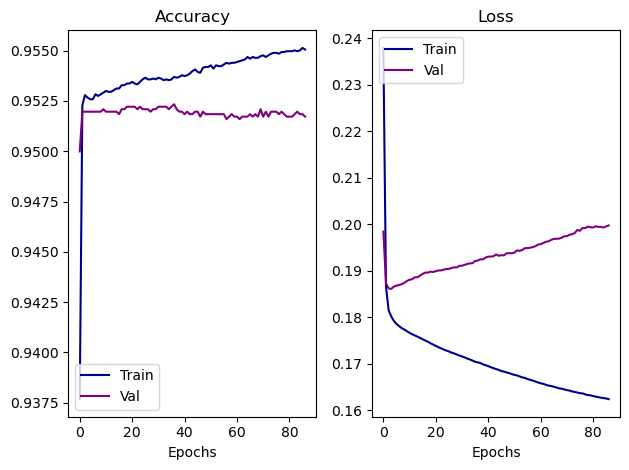

In [133]:
def plot_history(history):
    epochs = range(len(history["loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs,  history["accuracy"], color = "darkblue",  label="Train")
    plt.plot(epochs,  history["val_accuracy"], color = "purple", label="Val")
    plt.legend(loc="lower left")
    plt.xlabel("Epochs")
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs,  history["loss"], color = "darkblue", label="Train")
    plt.plot(epochs,  history["val_loss"], color = "purple", label="Val")
    plt.legend(loc="upper left")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.tight_layout()

    plt.show()

plot_history(history)